praca wykonana na podstawie:
https://www.youtube.com/watch?v=a4Yfz2FxXiY

implementacja innego modelu sieci neuronowej na podstawie
https://github.com/TeaPearce/Conditional_Diffusion_MNIST/blob/main/script.py

Imports

In [3]:
import torch
#from einops import einsum
#from torch import einsum
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from torchvision import transforms 
from torch.utils.data import DataLoader,random_split , Dataset
from random import randint,random
import os

import math

Data-set test

In [4]:
def show_images(dataset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(dataset):
        print(img)
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0][0][0])
        print("sample:" + str(img[1][0]))

#data = torchvision.datasets.MNIST(root=".", download=True)
#show_images(data)

In [5]:
# Calculate 
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Calculates the beta values for each timestep in the range [start, end], for given timesteps.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 500
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 128
TRAIN_SPLIT = 0.9

# class FilteredMNIST(Dataset):
#     def __init__(self, root, transform=None, target_digit=6):
#         self.dataset = torchvision.datasets.MNIST(root=root, download=True, transform=transform)
#         self.target_digit = target_digit
#         self.indices = [i for i, (_, label) in enumerate(self.dataset) if label == self.target_digit]

#     def __len__(self):
#         return len(self.indices)

#     def __getitem__(self, idx):
#         return self.dataset[self.indices[idx]]

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),# resize to fit 64/64 format 
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    data_samples = torchvision.datasets.MNIST(root=".",download=True,transform=data_transform)
    
    print(data_samples[0])
 
    train_size = int(TRAIN_SPLIT * len(data_samples))
    test_size = len(data_samples) - train_size

    train,test = random_split(data_samples,[train_size,test_size])

    print("Data size: ", len(data_samples))
    print("Train size: ", train_size, " len(train):",len(train))
    print("Test size: ", test_size, " len(test):",len(test))

    return torch.utils.data.ConcatDataset([train,test])

def show_tensor_image(image, ax):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    ax.imshow(reverse_transforms(image))

data = load_transformed_dataset()
print(data)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 5)
Data size:  60000
Train size:  54000  len(train): 54000
Test size:  6000  len(test): 6000


In [7]:
# Simulate forward diffusion
elem = next(iter(dataloader))
image = elem[0]
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 9
stepsize = int(T/num_images)
ax = plt.gca()
plt.subplot(1, num_images+1, int(0/stepsize) + 1)
show_tensor_image(image, ax)
for idx in range(1, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    print(img[0][0].shape)
    ax = plt.gca()
    show_tensor_image(img[0], ax)

torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([64, 64])


In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1
        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out


def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store


Num params:  16054849


In [9]:
def get_loss(model, x_0, t, c):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t,c)
    return F.mse_loss(noise, noise_pred)

def get_class_representation(class_numbers, num_classes=10):
    one_hot = F.one_hot(class_numbers, num_classes=num_classes)
    return one_hot.to(torch.float32)

sampling

In [10]:
@torch.no_grad()
def sample_timestep(x, t,c_class):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t,c_class) / sqrt_one_minus_alphas_cumprod_t
    )

    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(num_of_plots = 1,number_to_generate = None):
    # Sample noise
    img_size = IMG_SIZE
    num_images = 10
    stepsize = int(T/num_images)
    fig, axes = plt.subplots(num_of_plots, num_images, figsize=(3*num_images, 3*num_of_plots))
    for generetion_number in range(num_of_plots):
        if number_to_generate != None:
            ntg = number_to_generate
        else:
            ntg = randint(0,9)
        print(ntg)
        img = torch.randn((1, 1, img_size, img_size))
        img_class = get_class_representation(torch.tensor([ntg]))
        for i in range(0,T)[::-1]:
            t = torch.full((1,), i, dtype=torch.long)
            img = sample_timestep(img, t, img_class)
            img = torch.clamp(img, -1.0, 1.0)
            if i % stepsize == 0:
                plot_idx = int(i / stepsize)
                ##print(f"Adding subplot [{generetion_number}, {plot_idx}]")
                if num_of_plots == 1:
                    ax = axes[plot_idx]
                else:
                    ax = axes[generetion_number, plot_idx]
                show_tensor_image(img.detach().cpu(), ax)
    plt.show()
device = "cpu"
model.loadModel("FULL_diffusal_model_110")
sample_plot_image(10)

8
4
5
2
9
5
9
9
6
9


Training

Epoch 110
Epoch 110 | step 0000 Loss: 0.007320070639252663 
Epoch 110 | step 0001 Loss: 0.008331687189638615 
Epoch 110 | step 0002 Loss: 0.009569943882524967 
Epoch 110 | step 0003 Loss: 0.008908981457352638 
Epoch 110 | step 0004 Loss: 0.007883075624704361 
Epoch 110 | step 0005 Loss: 0.009906713850796223 
Epoch 110 | step 0006 Loss: 0.007586820516735315 
Epoch 110 | step 0007 Loss: 0.008139512501657009 
Epoch 110 | step 0008 Loss: 0.009469049051404 
Epoch 110 | step 0009 Loss: 0.00800666119903326 
Epoch 110 | step 0010 Loss: 0.007493599317967892 
Epoch 110 | step 0011 Loss: 0.008925487287342548 
Epoch 110 | step 0012 Loss: 0.007509198039770126 
Epoch 110 | step 0013 Loss: 0.007382292300462723 
Epoch 110 | step 0014 Loss: 0.006953686010092497 
Epoch 110 | step 0015 Loss: 0.008024770766496658 
Epoch 110 | step 0016 Loss: 0.008712861686944962 
Epoch 110 | step 0017 Loss: 0.008273900486528873 
Epoch 110 | step 0018 Loss: 0.006960249040275812 
Epoch 110 | step 0019 Loss: 0.00650363881140

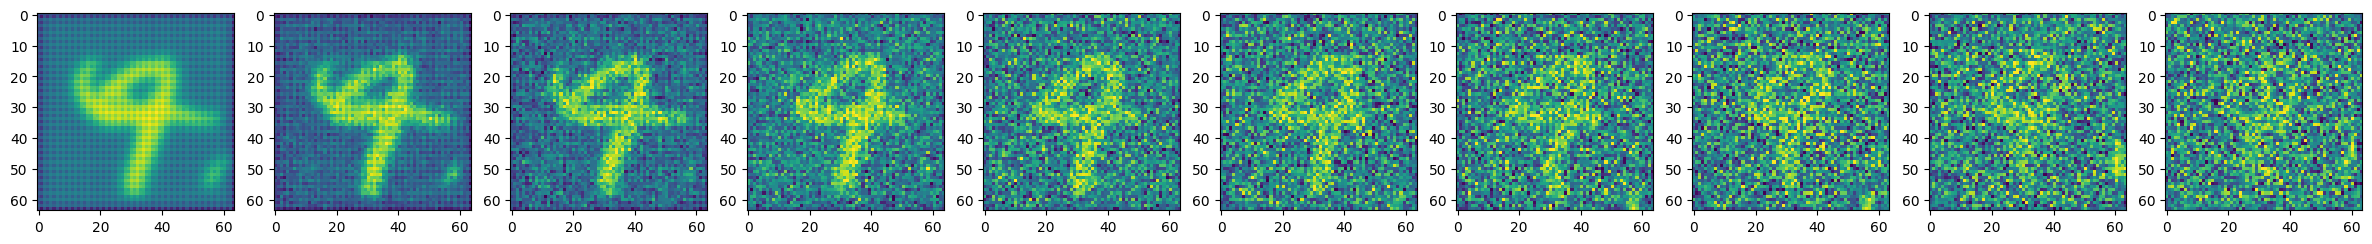

Epoch 111
Epoch 111 | step 0000 Loss: 0.00809655711054802 
Epoch 111 | step 0001 Loss: 0.006116767413914204 
Epoch 111 | step 0002 Loss: 0.007046313490718603 
Epoch 111 | step 0003 Loss: 0.008160079829394817 
Epoch 111 | step 0004 Loss: 0.007185396738350391 
Epoch 111 | step 0005 Loss: 0.007653213106095791 
Epoch 111 | step 0006 Loss: 0.008604016155004501 
Epoch 111 | step 0007 Loss: 0.007503419648855925 
Epoch 111 | step 0008 Loss: 0.0072363195940852165 
Epoch 111 | step 0009 Loss: 0.007255495525896549 
Epoch 111 | step 0010 Loss: 0.006445827428251505 
Epoch 111 | step 0011 Loss: 0.007187300827354193 
Epoch 111 | step 0012 Loss: 0.008038257248699665 
Epoch 111 | step 0013 Loss: 0.009205702692270279 
Epoch 111 | step 0014 Loss: 0.008659649640321732 
Epoch 111 | step 0015 Loss: 0.007434275466948748 
Epoch 111 | step 0016 Loss: 0.006757122930139303 
Epoch 111 | step 0017 Loss: 0.007827581837773323 
Epoch 111 | step 0018 Loss: 0.00766710052266717 
Epoch 111 | step 0019 Loss: 0.00902777165

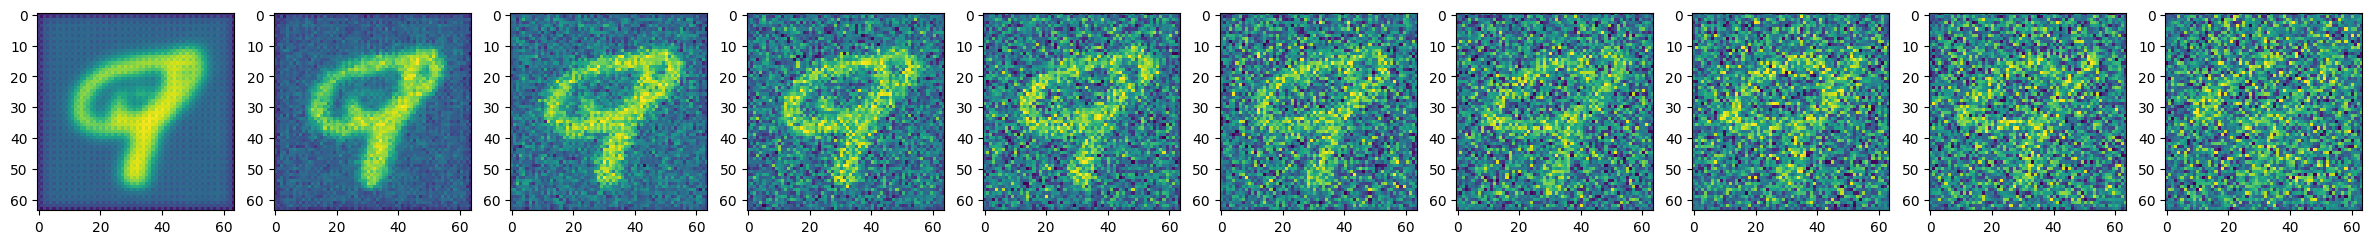

Epoch 116
Epoch 116 | step 0000 Loss: 0.00849688146263361 
Epoch 116 | step 0001 Loss: 0.007587325759232044 
Epoch 116 | step 0002 Loss: 0.007727386429905891 
Epoch 116 | step 0003 Loss: 0.006280452944338322 
Epoch 116 | step 0004 Loss: 0.008733140304684639 
Epoch 116 | step 0005 Loss: 0.007421042770147324 
Epoch 116 | step 0006 Loss: 0.007563656195998192 
Epoch 116 | step 0007 Loss: 0.006978518329560757 
Epoch 116 | step 0008 Loss: 0.006335059180855751 
Epoch 116 | step 0009 Loss: 0.00714486837387085 
Epoch 116 | step 0010 Loss: 0.007683390751481056 
Epoch 116 | step 0011 Loss: 0.007948489859700203 
Epoch 116 | step 0012 Loss: 0.008693968877196312 
Epoch 116 | step 0013 Loss: 0.008090194314718246 
Epoch 116 | step 0014 Loss: 0.0074157421477139 
Epoch 116 | step 0015 Loss: 0.007795237936079502 
Epoch 116 | step 0016 Loss: 0.007499773055315018 
Epoch 116 | step 0017 Loss: 0.006956083234399557 
Epoch 116 | step 0018 Loss: 0.007500397972762585 
Epoch 116 | step 0019 Loss: 0.00668210722506

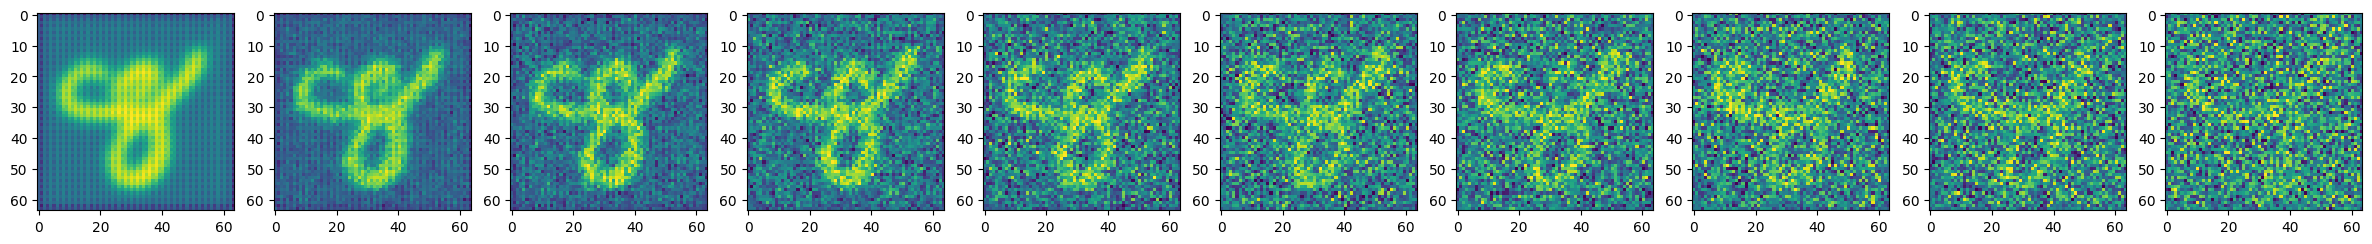

Epoch 121
Epoch 121 | step 0000 Loss: 0.007338970899581909 
Epoch 121 | step 0001 Loss: 0.008330358192324638 
Epoch 121 | step 0002 Loss: 0.008224780671298504 
Epoch 121 | step 0003 Loss: 0.006775308400392532 
Epoch 121 | step 0004 Loss: 0.0077393329702317715 
Epoch 121 | step 0005 Loss: 0.008284037001430988 
Epoch 121 | step 0006 Loss: 0.008409339003264904 
Epoch 121 | step 0007 Loss: 0.007558361627161503 
Epoch 121 | step 0008 Loss: 0.007249902002513409 
Epoch 121 | step 0009 Loss: 0.006847199518233538 
Epoch 121 | step 0010 Loss: 0.007455214858055115 
Epoch 121 | step 0011 Loss: 0.006930978503078222 
Epoch 121 | step 0012 Loss: 0.007445312105119228 
Epoch 121 | step 0013 Loss: 0.007391743827611208 
Epoch 121 | step 0014 Loss: 0.006911942269653082 
Epoch 121 | step 0015 Loss: 0.007099705282598734 
Epoch 121 | step 0016 Loss: 0.007737301755696535 
Epoch 121 | step 0017 Loss: 0.008939548395574093 
Epoch 121 | step 0018 Loss: 0.006658395752310753 
Epoch 121 | step 0019 Loss: 0.007506667

Epoch 126
Epoch 126 | step 0000 Loss: 0.008040381595492363 
Epoch 126 | step 0001 Loss: 0.008749580942094326 
Epoch 126 | step 0002 Loss: 0.00726285669952631 
Epoch 126 | step 0003 Loss: 0.007141807582229376 
Epoch 126 | step 0004 Loss: 0.0070623960345983505 
Epoch 126 | step 0005 Loss: 0.007014084607362747 
Epoch 126 | step 0006 Loss: 0.00862855277955532 
Epoch 126 | step 0007 Loss: 0.006363753229379654 
Epoch 126 | step 0008 Loss: 0.007298874668776989 
Epoch 126 | step 0009 Loss: 0.007245715707540512 
Epoch 126 | step 0010 Loss: 0.00659915478900075 
Epoch 126 | step 0011 Loss: 0.006899420637637377 
Epoch 126 | step 0012 Loss: 0.007788611575961113 
Epoch 126 | step 0013 Loss: 0.007605747319757938 
Epoch 126 | step 0014 Loss: 0.0075209904462099075 
Epoch 126 | step 0015 Loss: 0.007942961528897285 
Epoch 126 | step 0016 Loss: 0.007123315706849098 
Epoch 126 | step 0017 Loss: 0.0066253142431378365 
Epoch 126 | step 0018 Loss: 0.007709343917667866 
Epoch 126 | step 0019 Loss: 0.0084650535

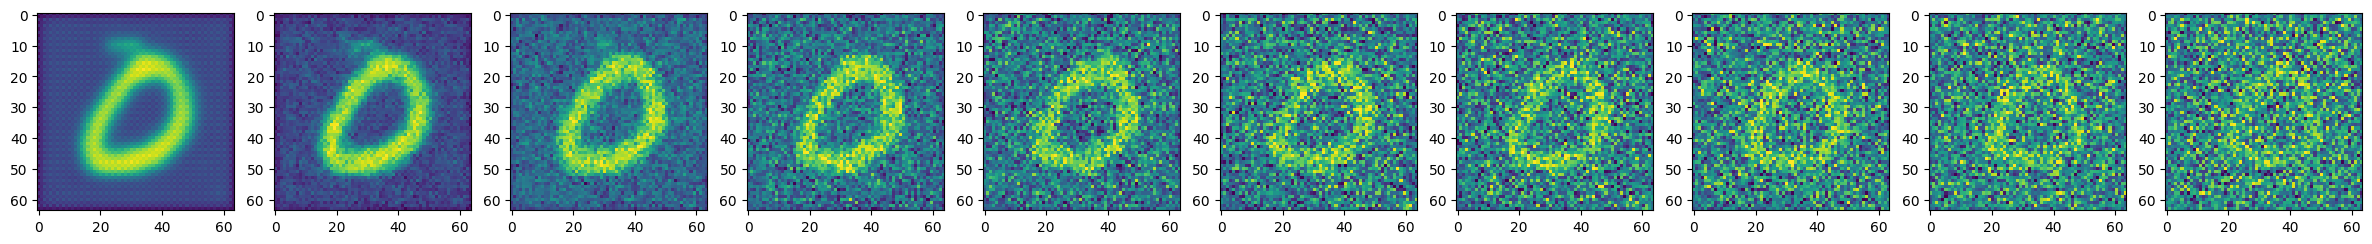

Epoch 131
Epoch 131 | step 0000 Loss: 0.006924469023942947 
Epoch 131 | step 0001 Loss: 0.009135534055531025 
Epoch 131 | step 0002 Loss: 0.007832663133740425 
Epoch 131 | step 0003 Loss: 0.008167645893990993 
Epoch 131 | step 0004 Loss: 0.00649443781003356 
Epoch 131 | step 0005 Loss: 0.006747320294380188 
Epoch 131 | step 0006 Loss: 0.0069370088167488575 
Epoch 131 | step 0007 Loss: 0.0075109656900167465 
Epoch 131 | step 0008 Loss: 0.007349676452577114 
Epoch 131 | step 0009 Loss: 0.007772477343678474 
Epoch 131 | step 0010 Loss: 0.007365471683442593 
Epoch 131 | step 0011 Loss: 0.00733081204816699 
Epoch 131 | step 0012 Loss: 0.006946074776351452 
Epoch 131 | step 0013 Loss: 0.007839624769985676 
Epoch 131 | step 0014 Loss: 0.007308320142328739 
Epoch 131 | step 0015 Loss: 0.00751808425411582 
Epoch 131 | step 0016 Loss: 0.008253827691078186 
Epoch 131 | step 0017 Loss: 0.007707696873694658 
Epoch 131 | step 0018 Loss: 0.00868489034473896 
Epoch 131 | step 0019 Loss: 0.008243167772

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.loadModel("FULL_diffusal_model_110")
model.to(device)
#show_images(dataset=dataloader)

optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 50 # Try more!

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
loss = torch.tensor([[0]])
torch.autograd.set_detect_anomaly(True)
for epoch in range(110,epochs+ 110):
    print(f"Epoch {epoch}")
    for step, batch in enumerate(dataloader):
      
      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

      loss = get_loss(model, batch[0], t,get_class_representation(batch[1]))
      loss.backward()
      optimizer.step()
      print(f"Epoch {epoch} | step {step:04d} Loss: {loss.item()} ")
    scheduler.step()

    if epoch % 5 == 0:
      model.saveModel("FULL_diffusal_model_"+str(epoch))
      if (epoch - 1)%(5) != 0 and os.path.exists("FULL_diffusal_model_"+str(epoch-1)):
        os.remove("FULL_diffusal_model_"+str(epoch-1))
      sample_plot_image()
